In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import linregress


warnings.filterwarnings('ignore')
plt.rcParams.update({"font.size": 11})
plt.rcParams.update({"axes.titlesize": 12})
plt.rcParams["font.family"] = "serif"
uparrow=f"\u2191"
downarrow=f"\u2193"

In [2]:
throughput_df = pd.read_csv("eval_res/throughput.csv")
throughput_df=throughput_df[throughput_df["wrapper"]=="base"]
backbone_df = pd.read_csv("backbones.csv")
display(throughput_df.head())
display(backbone_df.head())
merged_df = throughput_df.merge(backbone_df, on="model_name", how="left")
display(merged_df.head())

,model_name,source_or_wrapper,wrapper,batch_size,latency_sec,throughput_samples_per_sec
0,ConvNeXt_Base,torchvision,base,512,1.567112,326.715603
3,ConvNeXt_Large,torchvision,base,512,3.232451,158.393720
6,ConvNeXt_Small,torchvision,base,512,1.008226,507.822769
9,ConvNeXt_Tiny,torchvision,base,512,0.597364,857.098798
12,EfficientNet_B0,torchvision,base,512,0.178980,2860.647696


,model_name,architecture_family,source,tv_weights,Acc@1,Acc@5,Params,GFLOPS,Architecture,Year,Version
0,ConvNeXt_Base,ConvNeXt,torchvision,IMAGENET1K_V1,84.062,96.870,88.6,15.36,ConvNeXt_Base,2022.0,V1
1,ConvNeXt_Large,ConvNeXt,torchvision,IMAGENET1K_V1,84.414,96.976,197.8,34.36,ConvNeXt_Large,2022.0,V1
2,ConvNeXt_Small,ConvNeXt,torchvision,IMAGENET1K_V1,83.616,96.650,50.2,8.68,ConvNeXt_Small,2022.0,V1
3,ConvNeXt_Tiny,ConvNeXt,torchvision,IMAGENET1K_V1,82.520,96.146,28.6,4.46,ConvNeXt_Tiny,2022.0,V1
4,EfficientNet_B0,EfficientNet,torchvision,IMAGENET1K_V1,77.692,93.532,5.3,0.39,EfficientNet_B0,2019.0,V1


,model_name,source_or_wrapper,wrapper,batch_size,latency_sec,throughput_samples_per_sec,architecture_family,source,tv_weights,Acc@1,Acc@5,Params,GFLOPS,Architecture,Year,Version
0,ConvNeXt_Base,torchvision,base,512,1.567112,326.715603,ConvNeXt,torchvision,IMAGENET1K_V1,84.062,96.870,88.6,15.36,ConvNeXt_Base,2022.0,V1
1,ConvNeXt_Large,torchvision,base,512,3.232451,158.393720,ConvNeXt,torchvision,IMAGENET1K_V1,84.414,96.976,197.8,34.36,ConvNeXt_Large,2022.0,V1
2,ConvNeXt_Small,torchvision,base,512,1.008226,507.822769,ConvNeXt,torchvision,IMAGENET1K_V1,83.616,96.650,50.2,8.68,ConvNeXt_Small,2022.0,V1
3,ConvNeXt_Tiny,torchvision,base,512,0.597364,857.098798,ConvNeXt,torchvision,IMAGENET1K_V1,82.520,96.146,28.6,4.46,ConvNeXt_Tiny,2022.0,V1
4,EfficientNet_B0,torchvision,base,512,0.178980,2860.647696,EfficientNet,torchvision,IMAGENET1K_V1,77.692,93.532,5.3,0.39,EfficientNet_B0,2019.0,V1


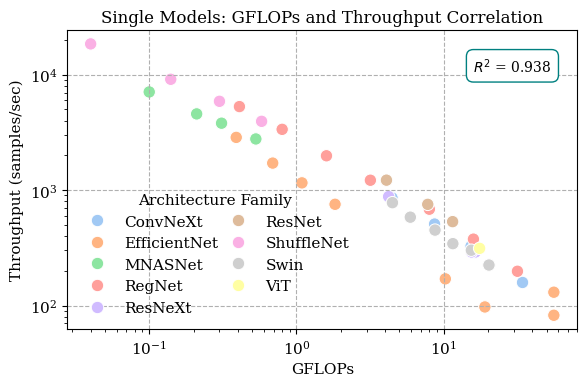

In [3]:
plot_df = merged_df[["GFLOPS", "throughput_samples_per_sec"]].dropna()
x = plot_df["GFLOPS"]
y = plot_df["throughput_samples_per_sec"]

merged_df.to_csv("temp.csv")

slope, intercept, r_value, p_value, std_err = linregress(np.log(x), np.log(y))
r_squared = r_value ** 2

# Plot
plt.figure(figsize=(6, 4))
sns.scatterplot(
    data=merged_df,
    x="GFLOPS",
    y="throughput_samples_per_sec",
    hue="architecture_family",
    palette="pastel",
    s=80
)
plt.xscale('log')
plt.yscale('log')
plt.grid(ls="--")
plt.xlabel("GFLOPs")
plt.ylabel("Throughput (samples/sec)")
plt.title("Single Models: GFLOPs and Throughput Correlation")
legend = plt.legend(
    title="Architecture Family",
    loc="lower left",
    ncol=2,
    frameon=False,
    columnspacing=0.3
)
# Add annotation
plt.text(
    0.95, 0.85,
    f"$R^2$ = {r_squared:.3f}",
    transform=plt.gca().transAxes,
    ha='right',
    va='bottom',
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.5",fc="white", ec="teal")
)

plt.tight_layout()
plt.savefig("pdf/throughput_single.pdf", bbox_inches="tight")

In [4]:
# Filter single model entries (exclude actual duo rows)
single_df = merged_df[merged_df["source_or_wrapper"] != "duo"]

# Prepare needed columns
cols = ["model_name", "GFLOPS", "throughput_samples_per_sec","architecture_family"]
print(f"{single_df.shape}")
single_df = single_df[cols].dropna()
print(f"{single_df.shape}")

# Rename for clarity in merge later
single_df = single_df.rename(columns={
    "model_name": "model",
    "GFLOPS": "gflops",
    "throughput_samples_per_sec": "throughput"
})

# Cross join (all possible model pairs)
pairs = pd.merge(single_df, single_df, how="cross", suffixes=("_large", "_small"))

# Filter: large must be strictly larger in GFLOPS
pairs = pairs[pairs["gflops_large"] > pairs["gflops_small"]].copy()

# Compute desired metrics
pairs["gflops_balance"] = pairs["gflops_small"] / pairs["gflops_large"]
pairs["gflops_total"] = pairs["gflops_small"] + pairs["gflops_large"]
pairs["gflops_additional_perc"] = pairs["gflops_balance"]*100

pairs["throughput_balance"] = 1/ (pairs["throughput_small"] / pairs["throughput_large"])
pairs["throughput_duo"] = 1 / (1 / pairs["throughput_large"] + 1 / pairs["throughput_small"])
pairs["throughput_slowdown"]= (1 - pairs["throughput_duo"] / pairs["throughput_large"])*100
display(pairs.head())
print(pairs.columns)
# Final rename
duo_throughput = pairs.rename(columns={
    "model_large": "model_large",
    "model_small": "model_small",
    "gflops_large": "gflops_large",
    "gflops_small": "gflops_small",
    "throughput_large": "throughput_large",
    "throughput_small": "throughput_small",
    
})[[
    "model_large", "model_small",
    "architecture_family_small","architecture_family_large",
    "gflops_large", "gflops_small", "gflops_balance", "gflops_total", "gflops_additional_perc",
    "throughput_large", "throughput_small", "throughput_balance", "throughput_duo", "throughput_slowdown"
]]

# display(single_df)
single_df.sort_values("gflops",ascending=False)["model"].head(5)

(42, 16)
(40, 4)


,model_large,gflops_large,throughput_large,architecture_family_large,model_small,gflops_small,throughput_small,architecture_family_small,gflops_balance,gflops_total,gflops_additional_perc,throughput_balance,throughput_duo,throughput_slowdown
2,ConvNeXt_Base,15.36,326.715603,ConvNeXt,ConvNeXt_Small,8.68,507.822769,ConvNeXt,0.565104,24.04,56.510417,0.643365,198.808860,39.149261
3,ConvNeXt_Base,15.36,326.715603,ConvNeXt,ConvNeXt_Tiny,4.46,857.098798,ConvNeXt,0.290365,19.82,29.036458,0.381188,236.546836,27.598549
4,ConvNeXt_Base,15.36,326.715603,ConvNeXt,EfficientNet_B0,0.39,2860.647696,EfficientNet,0.025391,15.75,2.539063,0.114210,293.226140,10.250341
5,ConvNeXt_Base,15.36,326.715603,ConvNeXt,EfficientNet_B1,0.69,1713.064722,EfficientNet,0.044922,16.05,4.492188,0.190720,274.384926,16.017196
6,ConvNeXt_Base,15.36,326.715603,ConvNeXt,EfficientNet_B2,1.09,1154.970656,EfficientNet,0.070964,16.45,7.096354,0.282878,254.673978,22.050255


Index(['model_large', 'gflops_large', 'throughput_large',
       'architecture_family_large', 'model_small', 'gflops_small',
       'throughput_small', 'architecture_family_small', 'gflops_balance',
       'gflops_total', 'gflops_additional_perc', 'throughput_balance',
       'throughput_duo', 'throughput_slowdown'],
      dtype='object')


40    tf_efficientnetv2_l.in21k_ft_in1k
10                    EfficientNet_V2_L
1                        ConvNeXt_Large
19                        RegNet_X_32GF
37                            Swin_V2_B
Name: model, dtype: object

In [5]:
f_large = "ConvNeXt_Base"

(28, 14)


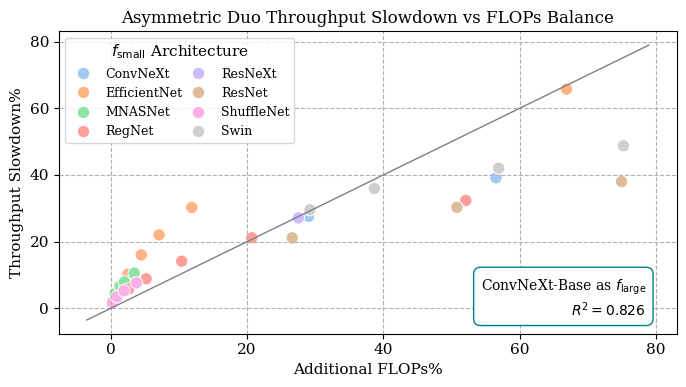

In [6]:

temp_df = duo_throughput[duo_throughput["model_large"]==f_large].sort_index(ignore_index=True)
print(temp_df.shape)

x = temp_df["gflops_additional_perc"]
y = temp_df["throughput_slowdown"]
slope, intercept, r_value, p_value, std_err = linregress(x, y)
r_squared = r_value ** 2

# Plot
plt.figure(figsize=(7, 4))
sns.scatterplot(
    data=temp_df,
    x="gflops_additional_perc",
    y="throughput_slowdown",
    hue="architecture_family_small",
    palette="pastel",
    s=80
)
plt.xlabel("Additional FLOPs%")
plt.ylabel("Throughput Slowdown%")
plt.title("Asymmetric Duo Throughput Slowdown vs FLOPs Balance")
lims = plt.gca().get_xlim()  # get current x-axis limits
plt.plot(lims, lims, color="gray", linestyle="-", linewidth=1)
plt.grid(True, linestyle="--")

# Legend
plt.legend(
    title="$f_{\mathrm{small}}$ Architecture",
    loc="upper left",
    ncol=2,
    frameon=True,
    columnspacing=0.3,
    fontsize=9
)

# R² annotation
plt.text(
    0.95, 0.05,
    f"{f_large.replace('_', '-')} as $f_{{\mathrm{{large}}}}$\n$R^2 = {r_squared:.3f}$",
    transform=plt.gca().transAxes,
    ha='right',
    va='bottom',
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="teal")
)

plt.tight_layout()
plt.savefig("pdf/throughput_duo.pdf", bbox_inches="tight")